In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, max_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [32]:
df_option = pd.read_pickle("TQQQ_trainning_master_data.pkl")

In [33]:
df_option.columns

Index(['Target_spread', 'tqqq_prior_std', 'tqqq_Vol', 'tqqq_pr_spread',
       'tqqq_prior_range', 'tqqq_cut_open', 'tqqq_cut_1hr', 'tqqq_cut_2hr',
       'tqqq_cut_3hr', 'vix_prior_std', 'vix_pr_spread', 'vix_prior_range',
       'vix_cut_open', 'vix_cut_1hr', 'vix_cut_2hr', 'vix_cut_3hr'],
      dtype='object')

In [34]:
len(df_option.columns)

16

<Axes: >

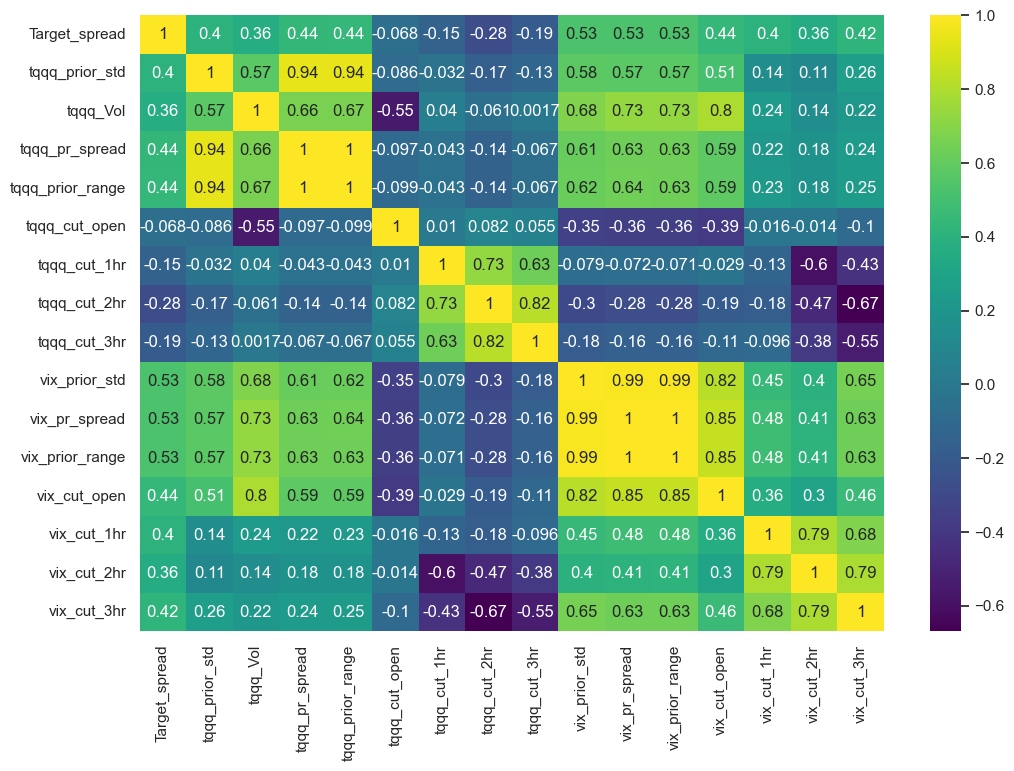

In [35]:
plt.figure(figsize=(12,8))
sns.heatmap(df_option.corr(numeric_only=True),cmap='viridis',annot=True)

<Axes: ylabel='Frequency'>

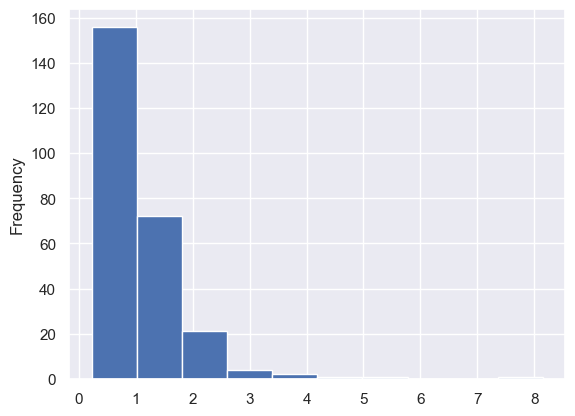

In [36]:
df_option.Target_spread.plot.hist()

In [ ]:
#sns.catplot(x='OP_EXP',y='Target_std',data=df_option, kind='box')

In [37]:
df_option.reset_index(inplace=True)

## Splitting the Data


In [38]:
X = df_option.drop(['Date_Only','Target_spread'], axis=1)  
#y = df_option['Target_std']
y = df_option['Target_spread']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [40]:
X_train.columns

Index(['tqqq_prior_std', 'tqqq_Vol', 'tqqq_pr_spread', 'tqqq_prior_range',
       'tqqq_cut_open', 'tqqq_cut_1hr', 'tqqq_cut_2hr', 'tqqq_cut_3hr',
       'vix_prior_std', 'vix_pr_spread', 'vix_prior_range', 'vix_cut_open',
       'vix_cut_1hr', 'vix_cut_2hr', 'vix_cut_3hr'],
      dtype='object')

In [41]:
X_train.shape

(206, 15)

In [42]:
y_train.shape

(206,)

## Evaluation Run Model with the Data


In [13]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,preds)
    print(f'mae : {mae}')
   
    
    plt.figure(figsize=(12,8),dpi=200)
    plt.scatter(y_test, preds)
    plt.plot(y_test, y_test, color='green', linestyle='dashed')
    plt.xlabel('real_std')

    return model

----

## Support Vector Regression

In [14]:
from sklearn.svm import SVR

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
svr_scaler = StandardScaler()
sc_X_train = svr_scaler.fit_transform(X_train)
sc_X_test = svr_scaler.transform(X_test)

In [17]:
param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale']}
svr = SVR()

In [18]:
grid = GridSearchCV(svr,param_grid)

mae : 0.5240164558613623


GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 100, 1000],
                         'gamma': ['auto', 'scale']})

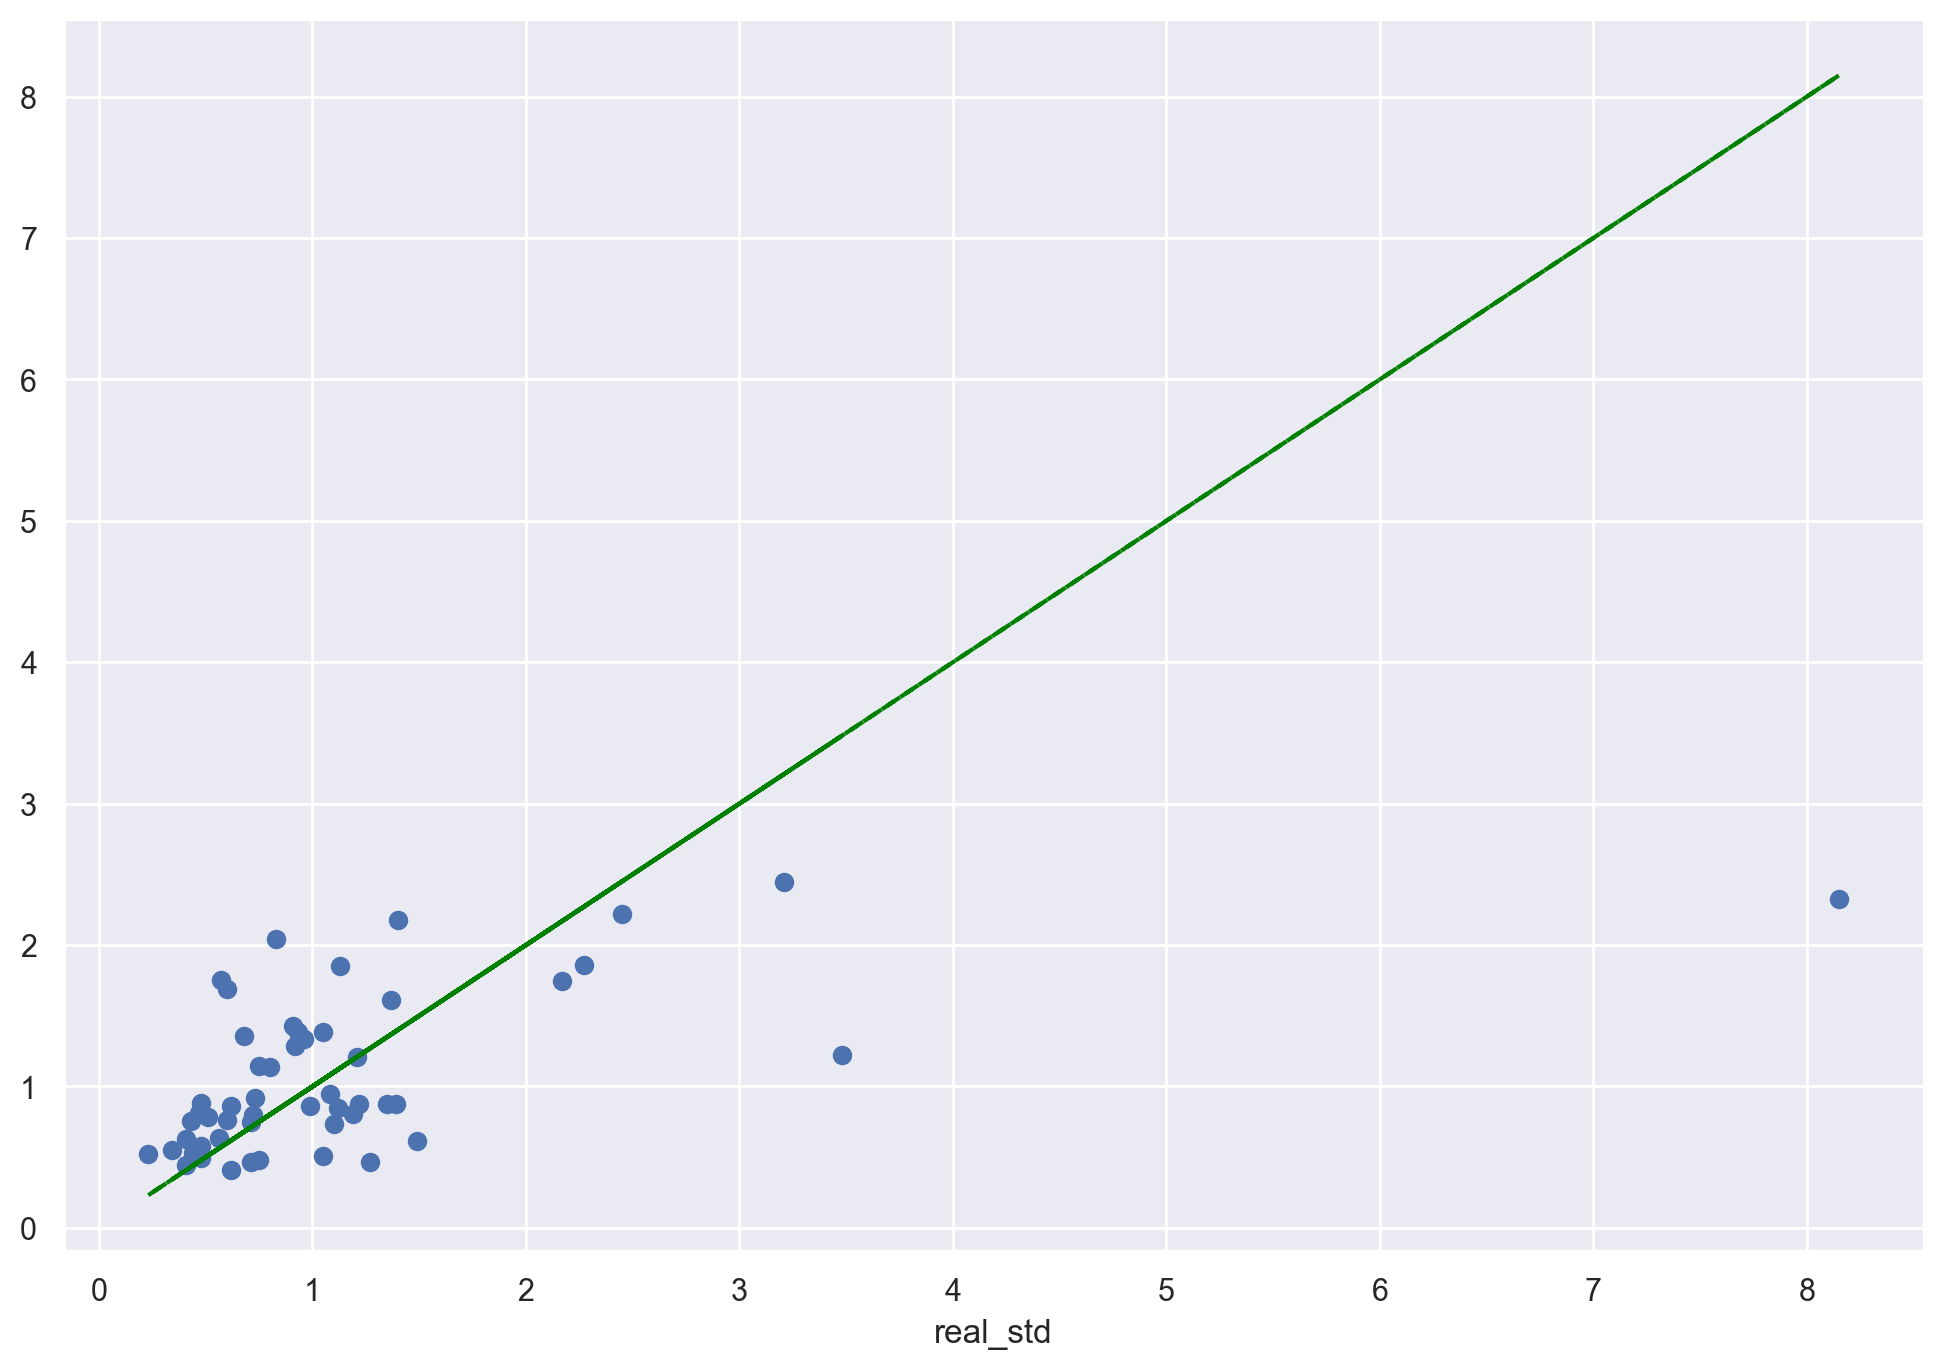

In [19]:
run_model(grid,sc_X_train,y_train,sc_X_test,y_test)

In [20]:
scaler_filename = "scaler4svr_TQQQ.save"
joblib.dump(svr_scaler, scaler_filename)

['scaler4svr_TQQQ.save']

In [21]:
SVR_model = grid.best_estimator_

In [22]:
filename = 'SVR_model_TQQQ.joblib'
joblib.dump(SVR_model, filename)

['SVR_model_TQQQ.joblib']

---

## Random Forest Regression

## Gradient Boosting


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
# help(GradientBoostingRegressor)

mae : 0.5405014183100995


GradientBoostingRegressor()

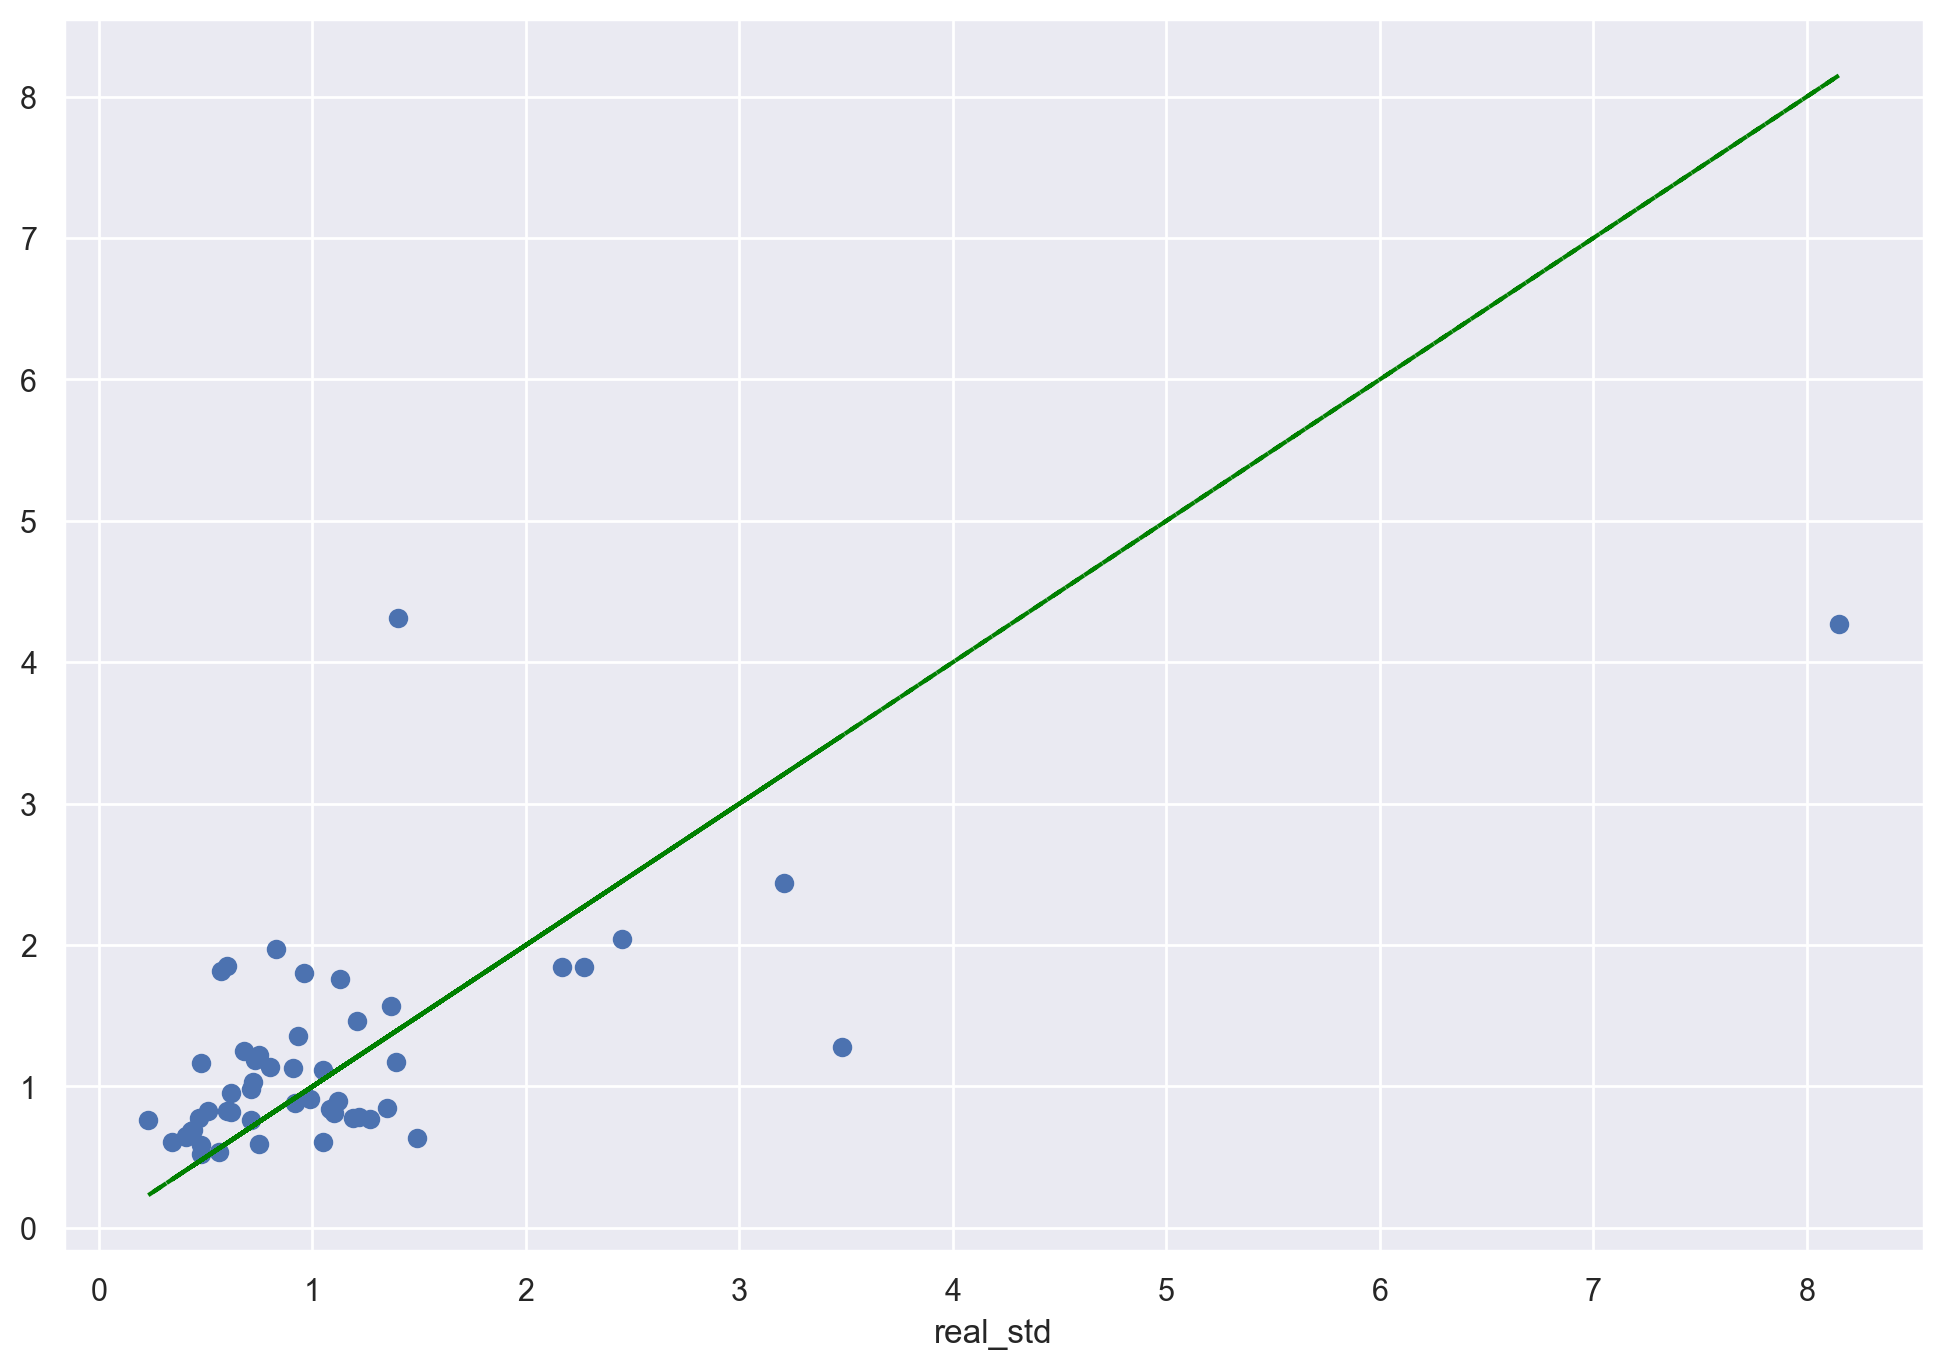

In [25]:
   
gbr_model = GradientBoostingRegressor()

run_model(gbr_model,X_train,y_train,X_test,y_test)

In [43]:
import xgboost as xgb
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Initialize XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgbr,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=10,
                           verbose=0,
                          n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", np.sqrt(-grid_search.best_score_))

# Evaluate the best model on the test set
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}
Best score: 0.5836885337034016
Test RMSE: 0.9694578864378214


mae : 0.5334070531680042


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

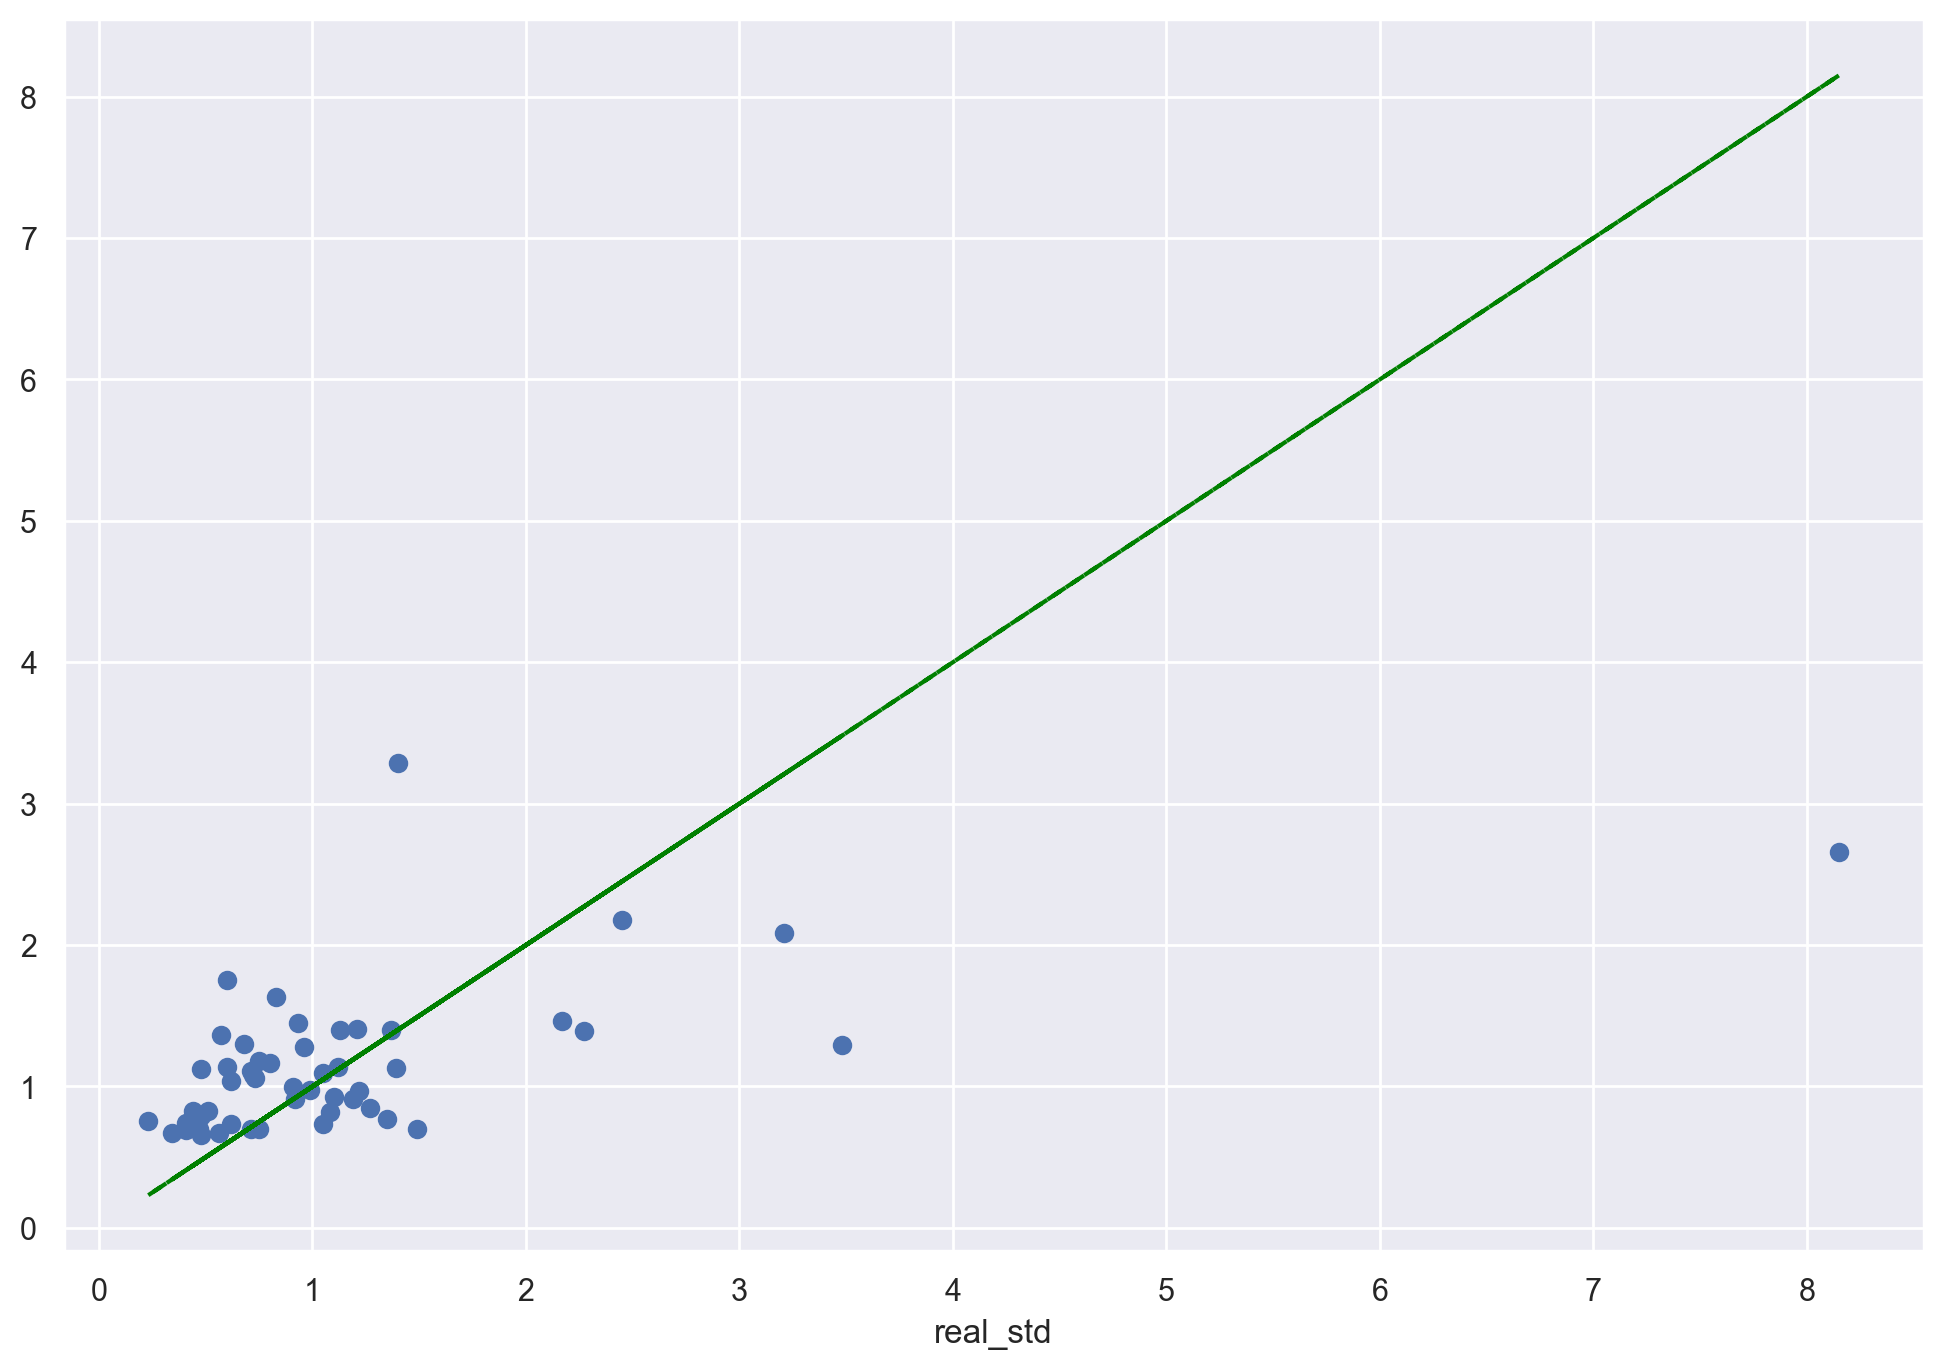

In [44]:
run_model(best_xgb_model,X_train,y_train,X_test,y_test)

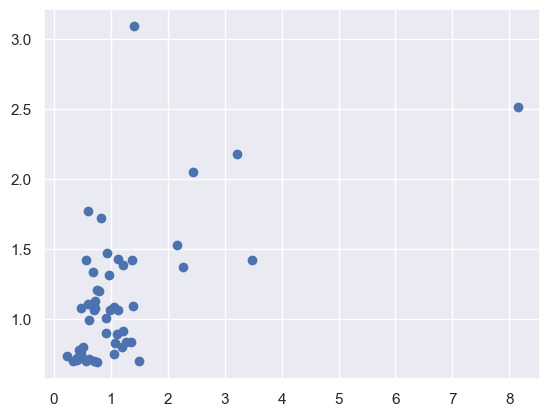

In [28]:
plt.scatter(y_test, best_xgb_model.predict(X_test))

In [ ]:
pd.DataFrame(index=X.columns,data=best_xgb_model.feature_importances_,columns=['Feature Importance'])

In [ ]:
X_train

In [45]:
import joblib
# Assuming 'model' is your trained model object
filename = 'xgb_model_TQQQ_price_spread.joblib'
joblib.dump(best_xgb_model, filename)


['xgb_model_TQQQ_price_spread.joblib']

In [ ]:
## ANN

In [31]:
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [30]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
scaler = MinMaxScaler()
MM_X_train= scaler.fit_transform(X_train)
MM_X_test = scaler.transform(X_test)

In [ ]:
DN_model = Sequential()

DN_model.add(Dense(23,activation='tanh'))
DN_model.add(Dense(46,activation='tanh'))
DN_model.add(Dense(45,activation='tanh'))
DN_model.add(Dense(23,activation='tanh'))
DN_model.add(Dense(1))

DN_model.compile(optimizer='adam',loss='mse')

In [ ]:
DN_model.fit(x=MM_X_train,y=y_train.values,
          validation_data=(MM_X_test,y_test.values),
          batch_size=128,epochs=300)

In [ ]:
losses = pd.DataFrame(DN_model.history.history)

In [ ]:
losses.plot()

In [ ]:
predic = DN_model.predict(MM_X_test)

In [ ]:
plt.scatter(y_test, predic)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [ ]:
mean_absolute_error(y_test,predic)

In [ ]:
explained_variance_score(y_test,predic)

In [ ]:
import joblib
# Assuming 'model' is your trained model object
filename = 'DN_model48_price_spread.joblib'
joblib.dump(DN_model, filename)

In [ ]:
### stacking##


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Define base models
estimators = [
    ('xg', best_xgb_model),
    ('mlp',MLPRegressor(hidden_layer_sizes=(23,23,16,8), activation='relu', random_state=42, max_iter=500)),
]

# Define meta-model
meta_model = LinearRegression()

# Create stacking regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_model)

# Train stacking regressor
stacking_regressor.fit(X_train, y_train)

# Make predictions
y_pred = stacking_regressor.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

----

In [ ]:
plt.scatter(y_test, y_pred)